**Modèle de classification des images**
-----------------
Ce notebook a objectif de mettre en place un modèle pour classifier les différents produits selon l'image associée.<br>
J'utilise le modèle EfficientNetB0, qui est un modèle de classification d'images très performant avec le meilleur compromis entre la précision, la vitesse et la légereté.<br>


On procéde en 3 étapes :
- **Séparation des données d'entrainement, de validation et de test**
- **Entraînement du modèle EfficientNetB0 selon plusieurs scénarios** : Sans les poids du modèle entrainés (from scratch), en utilisant le Transfer Learning sur les poids pré-entrainés avec plusieurs variations : avec/sans dégel de certaines couches et avec/sans data augmentation.
- **Mesure de l'accuracy du modèle sur le jeu de test**

# **Imports**

In [1]:
# Autres imports
import pandas as pd
import os
import warnings

import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Model

# Utilise la fonction de display de sklearn pour afficher la matrice de confusion
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

In [2]:
# Définit le nombre de coeurs utilisés à 10
os.environ['LOKY_MAX_CPU_COUNT'] = '10'

# Filtre les user warning de keras
warnings.filterwarnings('ignore', category=UserWarning)

# **Chargement des données nettoyées**

In [3]:
image_df = pd.read_pickle('flipkart_cleaned.pkl')
image_df.drop(columns=['product_name', 'description'], inplace=True)
print(image_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   image   1050 non-null   object  
 1   class   1050 non-null   category
dtypes: category(1), object(1)
memory usage: 9.4+ KB
None


Pour la suite du travail, je vais utiliser les données nettoyées et préparées dans le notebook précédent sur les images.<br>
J'assigne également le nombre de classes à prédire ainsi que la liste des classes dans 2 variables.

In [4]:
# Assigne le nombre de classes
n_classes = image_df['class'].nunique()

# Assigne la liste des classes
labels = list(image_df['class'].unique())

# **Séparation des données en train-test-split**

In [5]:
# train test split avec un jeu de test de 20%
X_train, X_test, y_train, y_test = train_test_split(image_df['image'], image_df['class'], test_size=0.2, random_state=314, stratify=image_df['class'])

# Regroupement des données en dataframe de train et de test
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

# **Evaluation des différents scénarios de modélisation**

Ma démarche pour évaluer les différents scénarios de modélisation est itérative.<br>
Je commence par un scénario simple et j'ajoute des complexités au fur et à mesure pour voir l'impact sur la performance du modèle. <br>
**Notre scénario de départ est d'entraîner le modèle sans les poids pré-entrainés (from scratch) et sans data augmentation.**<br>
Ensuite, j'ajoute des complexités en utilisant le Transfer Learning sur les poids pré-entrainés avec plusieurs variations : avec/sans dégel de certaines couches et avec/sans data augmentation.<br>


La métrie d'évaluation que je vais utiliser est l'accuracy.<br>
Je vais comparer les performances des différents scénarios en termes de temps d'entraînement et de performance sur le jeu de test.


## **Fonctions de modélisation**

Je définis ici les fonctions qui vont me permettre de modéliser les différents scénarios.<br>
Je vais utiliser la librairie TensorFlow et Keras pour construire et entraîner les modèles.<br>
Je vais également utiliser la librairie Scikit-learn pour évaluer les performances des modèles.


Les deux fonctions principales sont :
- **compile le modèle et l'entraine** : qui permet de construire le modèle EfficientNetB0 avec les différentes variations selon le scénario choisi.
- **compile les données de train, validation et test** : qui permet de préparer les données pour l'entrainement sous forme de générateur. On pourra y ajouter la data augmentation si nécessaire.

In [6]:
def create_test_generator(data: pd.DataFrame, image_size: tuple = (224, 224), batch_size: int = 32, preprocess=efficientnet_preprocess_input) -> tf.keras.preprocessing.image.DirectoryIterator:
    # Création d'un Image Data Generator avec la fonction de preprocessing d'EfficientNet
    datagen = ImageDataGenerator(
        preprocessing_function=preprocess
    )

    # Création du générateur de données à partir du dataframe de test
    test_generator = datagen.flow_from_dataframe(
        data,
        directory='images/',
        x_col='image',
        y_col='class',
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False  # On ne mélange pas les données comme elles ne servent qu'à l'évaluation
    )

    # Retourne le datagenerator de test
    return test_generator

Concernant la fonction pour compiler le modèle, on fixe certains éléments tels que :
- **l'optimizer** : Adam avec le learning rate à préciser
- **la loss function** : categorical_crossentropy
- **les métriques** : accuracy
- **le batch size** : 32
- **le ratio du validation split** : 0.2
- **EarlyStopping** : pour éviter le sur-apprentissage avec un seuil de patience de 5 epochs sur la validation loss
- **ModelCheckpoint** : pour sauvegarder le meilleur modèle sur la validation loss


In [7]:
def compile_and_fit(model: tf.keras.Model, N_EPOCHS: int, LEARNING_RATE: float, scenario: str, data_augmentation_params: dict = None, preprocess=efficientnet_preprocess_input) -> tf.keras.callbacks.History:
    # Vérifie que model est bien un modèle Keras
    assert isinstance(model, tf.keras.Model), 'model doit être un modèle Keras'
    # Vérifie que N_EPOCHS est bien un entier
    assert isinstance(N_EPOCHS, int), 'N_EPOCHS doit être un entier'
    # Vérifie que LEARNING_RATE est bien un flottant
    assert isinstance(LEARNING_RATE, float), 'LEARNING_RATE doit être un flottant'
    # Vérifie que scenario est bien une chaîne de caractères
    assert isinstance(scenario, str), 'scenario doit être une chaîne de caractères'
    # Vérifie que data_augmentation_params est bien un dictionnaire ou None
    assert data_augmentation_params is None or isinstance(data_augmentation_params, dict), 'data_augmentation_params doit être un dictionnaire ou None'

    # Assigne les paramètres de data augmentation ou pas pour le datagenerator
    if data_augmentation_params is not None:
        datagen = ImageDataGenerator(
            preprocessing_function=preprocess, # Prétraitement EfficientNet
            validation_split=0.2, # 20% des données pour la validation
            **data_augmentation_params # Paramètres de data augmentation
        )
    else:
        datagen = ImageDataGenerator(
        preprocessing_function=preprocess, # Prétraitement EfficientNet
        validation_split=0.2 # 20% des données pour la validation
        )

    # Crée les générateurs de données du train à partir du dataframe de train
    train_generator = datagen.flow_from_dataframe(
        dataframe=train,
        directory='images',
        x_col='image',
        y_col='class',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        shuffle=True,
        subset='training'
    )

    # Crée les générateurs de données de validation à partir du dataframe de train
    validation_generator = datagen.flow_from_dataframe(
        dataframe=train,
        directory='images',
        x_col='image',
        y_col='class',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        shuffle=False,
        subset='validation'
    )

    # Compile le modèle avec le LEARNING_RATE désiré
    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Définir le callback EarlyStopping
    early_stopping = EarlyStopping(
    monitor='val_loss',  # Surveiller la perte de validation (ou 'val_accuracy' pour la précision de validation)
    patience=5,          # Arrêter l'entraînement après 5 epochs sans amélioration
    min_delta=0.001,     # Seuil de tolérance pour l'amélioration
    mode='min',          # Utiliser 'min' pour la perte (ou 'max' pour 'val_accuracy')
    verbose=1            # Afficher un message lorsque l'entraînement est arrêté
    )

    # Définir le callback pour sauvegarder les poids du modèle
    checkpoint = ModelCheckpoint(
        scenario+'_best_model.weights.h5',
        save_weights_only=True,
        save_best_only=True,
        monitor='val_loss',
        mode='min',
        verbose=1)

    # Entraîne le modèle
    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=N_EPOCHS,
        callbacks=[early_stopping, checkpoint]
    )

    # Retourne l'historique de l'entraînement
    return history

## **Evaluation des modèles**

Je définis une fonction de visualisation sur les courbes d'apprentissage pour évaluer les performances des modèles sur les différentes jeux de données (train et validation).<br>

In [8]:
def plot_learning_curves(history: tf.keras.callbacks.History, scenario: str) -> None:
    # Crée une figure pour afficher les courbes d'apprentissage sur l'accuracy et la perte
    fig, ax = plt.subplots(1, 2, figsize=(14, 6), tight_layout=True)
    fig.suptitle(f"Evaluation scénario {scenario}", fontweight='bold', fontsize=16)
    # Affiche la courbe de l'accuracy
    ax[0].plot(history.history['accuracy'], label='train_accuracy')
    ax[0].plot(history.history['val_accuracy'], label='validation_accuracy')
    ax[0].set_title("Courbes d'apprentissage de l'accuracy", fontweight='bold')
    ax[0].set_ylabel('Accuracy')
    # Affiche la courbe de la perte
    ax[1].plot(history.history['loss'], label='train_loss')
    ax[1].plot(history.history['val_loss'], label='validation_loss')
    ax[1].set_title("Courbes d'apprentissage de la perte", fontweight='bold')
    ax[1].set_ylabel('Loss')
    for i in range(2):
        ax[i].set_xticks(range(0, n_epochs, 2))
        ax[i].set_xlabel('Epochs')
        ax[i].grid(axis='both', linestyle='--')
        ax[i].legend()
    plt.show()

In [9]:
# Crée une liste de scores pour chaque scénario
scores = []

### **Initialisation du dictionnaire de modèle et du test generator**

In [10]:
# Initialisation du dictionnaire avec les paramètres du modèle
model_params = dict()

In [11]:
# Création du génération de données de test
test_generator = create_test_generator(test)

Found 210 validated image filenames belonging to 7 classes.


In [12]:
# Affiche les couches de sortie du modèle
print("Les couches de sortie/output du modèle par défaut sont :")
pprint(EfficientNetB0(include_top=True, weights=None).layers[-3:])

Les couches de sortie/output du modèle par défaut sont :
[<GlobalAveragePooling2D name=avg_pool, built=True>,
 <Dropout name=top_dropout, built=True>,
 <Dense name=predictions, built=True>]


### **SCENARIO 1 - From scratch**

Le premier scénario consiste à entraîner le modèle sans les poids pré-entrainés (from scratch) et sans data augmentation.<br>
Je vais évaluer ce scénario pour voir la performance du modèle de base.<br>

In [13]:
# Définir les paramètres du modèle pour le scénario 1
scenario='1'
data_augmentation_params = None
LEARNING_RATE = 1e-4
N_EPOCHS = 20

# Enregistre les paramètres du modèle
model_params[scenario] = {
    'include_top': True,
    'weights': None,
    'input_shape': (224, 224, 3),
    'classes': n_classes,
    'classifier_activation': 'softmax'
}

# Charge le modèle EfficientNetB0
model = EfficientNetB0(**model_params[scenario])

# Rends les couches entraînables
model.trainable=True

# Entraîne le modèle et retourne les résultats
history = compile_and_fit(model, N_EPOCHS, LEARNING_RATE, scenario=scenario)

Found 672 validated image filenames belonging to 7 classes.
Found 168 validated image filenames belonging to 7 classes.
Epoch 1/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.1434 - loss: 2.9979

c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



Epoch 1: val_loss improved from inf to 1.94204, saving model to 1_best_model.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 123s 5s/step - accuracy: 0.1431 - loss: 2.9956 - val_accuracy: 0.1310 - val_loss: 1.9420
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.1641 - loss: 2.6925
Epoch 2: val_loss did not improve from 1.94204
21/21 ━━━━━━━━━━━━━━━━━━━━ 93s 4s/step - accuracy: 0.1641 - loss: 2.6950 - val_accuracy: 0.1310 - val_loss: 1.9706
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.2083 - loss: 2.4615
Epoch 3: val_loss did not improve from 1.94204
21/21 ━━━━━━━━━━━━━━━━━━━━ 93s 4s/step - accuracy: 0.2073 - loss: 2.4675 - val_accuracy: 0.1607 - val_loss: 1.9541
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.2119 - loss: 2.3095
Epoch 4: val_loss did not improve from 1.94204
21/21 ━━━━━━━━━━━━━━━━━━━━ 97s 5s/step - accuracy: 0.2117 - loss: 2.3107 - val_accuracy: 0.1310 - val_loss: 1.9602
Epoch 5/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy:

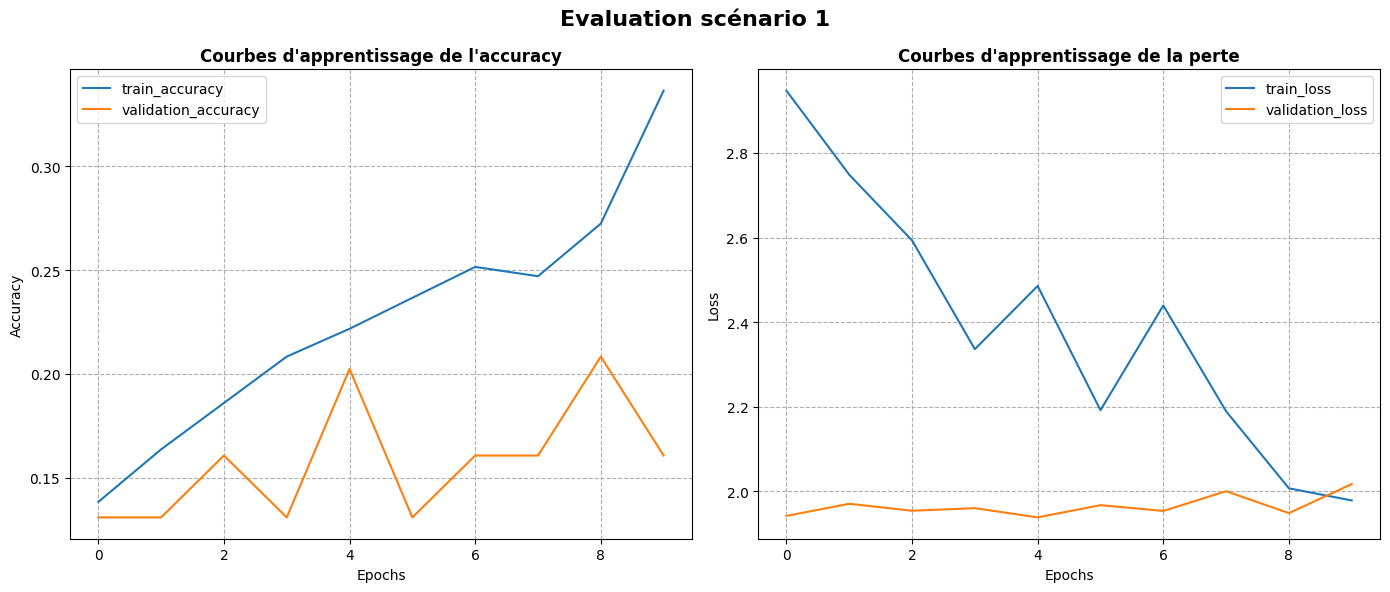

In [14]:
# Récupère le nombre d'EPOCHS utilisés
n_epochs = len(history.history['loss'])

# Affiche les courbes d'apprentissage
plot_learning_curves(history, scenario)

Le modèle apprends sur le jeu d'entraînement mais n'arrive pas à minimiser la loss sur le jeu de validation.<br>
Regardons la matrice de confusion pour voir les classes mal prédites.

In [15]:
# Définit le nom du modèle à charger
model_name = scenario+'_best_model.weights.h5'

# Charger les poids du modèle sauvegardés
model.load_weights(model_name)

# Évaluer le modèle avec les poids chargés
score = model.evaluate(test_generator)
print(f"Test loss: {score[0]}")
print(f"Test accuracy: {score[1]}")

# Ajoute les résultats à la liste de scores
scores.append((scenario, score[1], score[0]))

7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 984ms/step - accuracy: 0.1011 - loss: 1.9705
Test loss: 1.956160068511963
Test accuracy: 0.1428571492433548


7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step


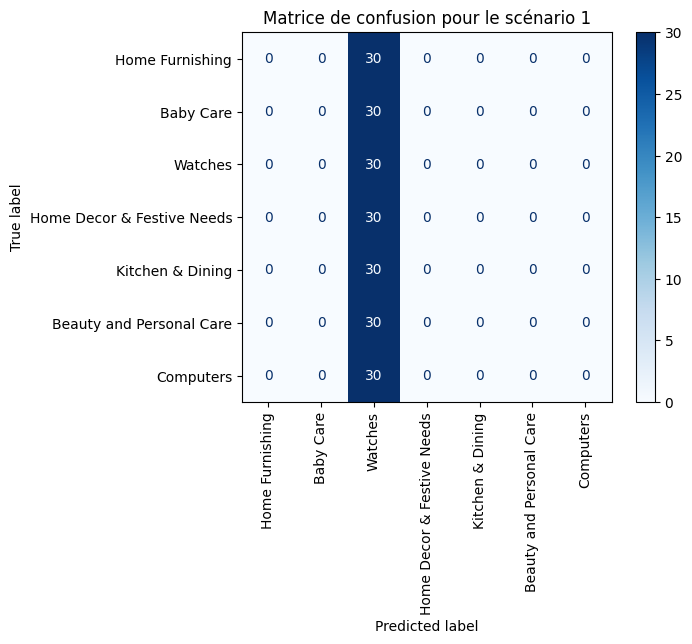

In [16]:
# Récupère les probabilités prédites par le modèle pour chaque classe
y_preds = model.predict(test_generator)

# Calcule la matrice de confusion
cm = confusion_matrix(test_generator.classes, y_preds.argmax(axis=1))

# Crée l'objet de display de la matrice de confusion
cm_display = ConfusionMatrixDisplay(cm, display_labels=labels)

# Affiche la matrice de confusion
cm_display.plot(cmap='Blues', xticks_rotation='vertical')
plt.title(f"Matrice de confusion pour le scénario {scenario}")
plt.show()


Le modèle n'arrive pas à prédire correctement les classes. On va essayer d'améliorer la performance en utilisant le Transfer Learning sur les poids pré-entrainés.<br>
Il a prédit uniquement la classe `Watches` lors de son entraînement.<br>
Entraîner le modèle from scratch prend beaucoup de temps et n'est pas recommandé avec aussi peu de données.<br>
Cela montre les limites d'un modèle sans les poids pré-entrainés.

### **SCENARIO 2a - Transfer Learning avec entraînement de l'output**

A présent, on va utiliser le Transfer Learning sur les poids pré-entrainés.<br>
Ainsi le modèle conserve les caractériques apprises sur les données ImageNet qui devraient logiquement être suffisantes pour des objets généralistes comme nos produits.<br>
On entraîne uniquement la dernière couche Dense pour prédire les classes de notre jeu de données.<br>
Les poids des autres couches restent figés.<br>

In [17]:
# SCENARIO 2A : On utilise les poids pré-entraînés sur ImageNet ET on reproduit les dernières couches de l'output du modèle
scenario = '2a'
data_augmentation_params = None
LEARNING_RATE = 1e-3
N_EPOCHS = 20

# Enregistre les paramètres du modèle
model_params[scenario] = {
    'include_top': False,
    'weights': 'imagenet',
    'input_shape': (224, 224, 3)
}

# Charge le modèle EfficientNetB0
model = EfficientNetB0(**model_params[scenario])

# Gèle toutes les couches du modèle
model.trainable = False

# Affiche les couches du modèle d'entrée et de sortie
print("Input: ", model.input)
print("Output: ", model.output)

# Ajoute les dernières couches denses du modèle
x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.2, name='top_dropout')(x)
predictions = tf.keras.layers.Dense(n_classes, activation='softmax', name='predictions')(x)

# Crée un modèle à partir des inputs et des outputs
model = Model(inputs=model.input, outputs=predictions)

# Entraine le modèle et affiche les résultats
history = compile_and_fit(model, N_EPOCHS, LEARNING_RATE, scenario=scenario)

Input:  <KerasTensor shape=(None, 224, 224, 3), dtype=float32, sparse=None, name=keras_tensor_480>
Output:  <KerasTensor shape=(None, 7, 7, 1280), dtype=float32, sparse=False, name=keras_tensor_717>
Found 672 validated image filenames belonging to 7 classes.
Found 168 validated image filenames belonging to 7 classes.
Epoch 1/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 860ms/step - accuracy: 0.3037 - loss: 2.2504

c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



Epoch 1: val_loss improved from inf to 1.01548, saving model to 2a_best_model.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.3121 - loss: 2.2224 - val_accuracy: 0.7679 - val_loss: 1.0155
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 867ms/step - accuracy: 0.7281 - loss: 0.7475
Epoch 2: val_loss improved from 1.01548 to 0.70795, saving model to 2a_best_model.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.7305 - loss: 0.7428 - val_accuracy: 0.8690 - val_loss: 0.7079
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 828ms/step - accuracy: 0.8263 - loss: 0.4434
Epoch 3: val_loss improved from 0.70795 to 0.62077, saving model to 2a_best_model.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.8273 - loss: 0.4430 - val_accuracy: 0.8750 - val_loss: 0.6208
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 827ms/step - accuracy: 0.8841 - loss: 0.3984
Epoch 4: val_loss improved from 0.62077 to 0.57263, saving model to 2a_best_model.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 2

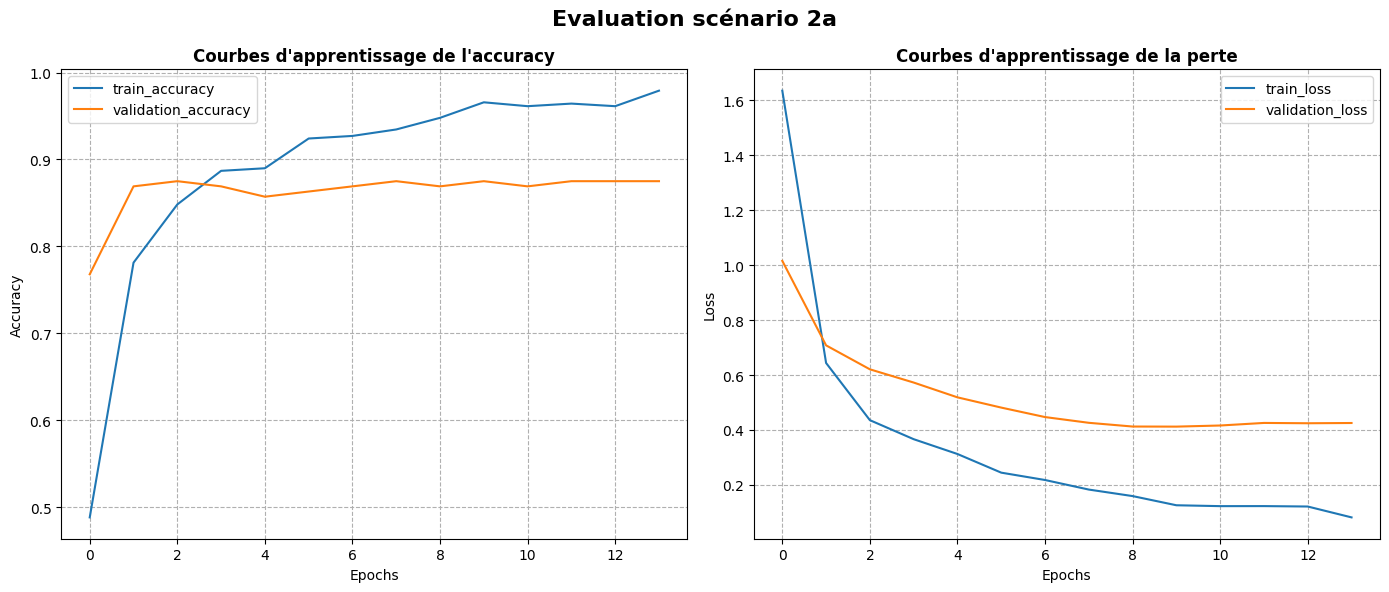

In [18]:
# Récupère le nombre d'EPOCHS utilisés
n_epochs = len(history.history['loss'])

# Affiche les courbes d'apprentissage
plot_learning_curves(history, scenario)

Le résultat est d'emblée très performant et on constate que le modèle a réussi à bien généraliser les données du validation split et l'EarlyStopping a mis un terme à l'entraînement au bout de 16 Epochs.<br>
Regardons les résultats sur le jeu de test:

In [19]:
# Définit le nom du modèle à charger
model_name = scenario+'_best_model.weights.h5'

# Charger les poids du modèle sauvegardés
model.load_weights(model_name)

# Évaluer le modèle avec les poids chargés
score = model.evaluate(test_generator)
print(f"Test loss: {score[0]}")
print(f"Test accuracy: {score[1]}")

# Ajoute les résultats à la liste de scores
scores.append((scenario, score[1], score[0]))

7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 841ms/step - accuracy: 0.7365 - loss: 0.8019
Test loss: 0.6622200608253479
Test accuracy: 0.7857142686843872


L'accuract est bonne sur le jeu de test mais en deçà de celle sur le jeu de validation.<br>
Regardons quelles sont les classes mal prédites:

7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step  


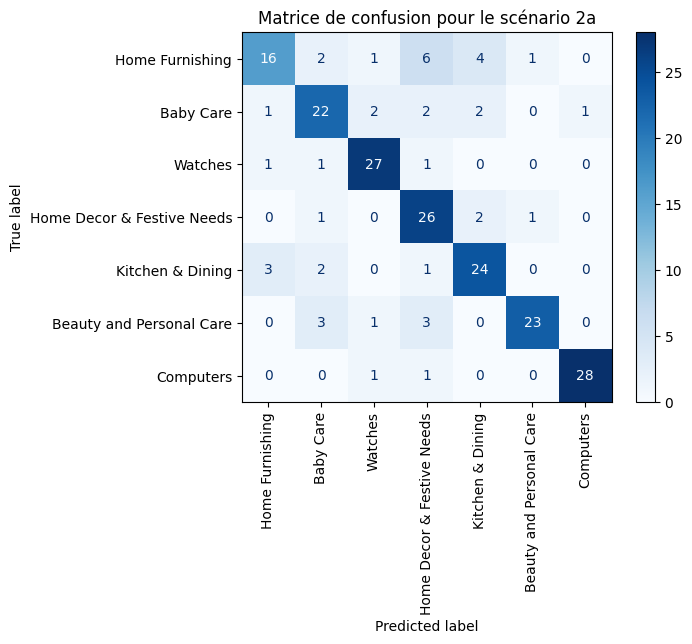

In [20]:
# Récupère les probabilités prédites par le modèle pour chaque classe
y_preds = model.predict(test_generator)

# Calcule la matrice de confusion
cm = confusion_matrix(test_generator.classes, y_preds.argmax(axis=1))

# Crée l'objet de display de la matrice de confusion
cm_display = ConfusionMatrixDisplay(cm, display_labels=labels)

# Affiche la matrice de confusion
cm_display.plot(cmap='Blues', xticks_rotation='vertical')
plt.title(f"Matrice de confusion pour le scénario {scenario}")
plt.show()


La classe `Home Furnishing` est la plus mal prédite avec beaucoup d'erreurs de classification notamment sur `Home Decor & Festive Needs` et `Kitchen & Dining`.<br>
La classe `baby care` a plusieurs mauvaises prédictions notamment sur `Home Decor & Festive Needs`.<br>
Le modèle aurait besoin de plus de données pour mieux généraliser sur ces classes.<br>

### **SCENARIO 2b - Transfer Learning avec l'output modifié avec G_AVG_POOL + 1xDENSE FC**

Pour tenter d'améliorer les performances du modèle, comme nous n'avons pas plus d'images, on va tester d'autres scénarios.<br>
A commencer par remplacer les couches de l'output du modèle par une couche GlobalAveragePooling2D et une couche Dense.<br>
Nous n'avons pas beaucoup de classes à prédire et cela pourrait aider le modèle à mieux généraliser.<br>

In [21]:
# SCENARIO 2B : On utilise les poids pré-entraînés sur ImageNet ET avec une sortie sans régularisation avec deux dense hidden layer.
scenario = '2b'
data_augmentation_params = None
LEARNING_RATE = 1e-3
N_EPOCHS = 20

# Enregistre les paramètres du modèle
model_params[scenario] = {
    'include_top': False,
    'weights': 'imagenet',
    'input_shape': (224, 224, 3)
}

# Charge le modèle EfficientNetB0
model = EfficientNetB0(**model_params[scenario])

# Gèle toutes les couches du modèle
model.trainable = False

# Affiche les couches du modèle d'entrée et de sortie
print("Input: ", model.input)
print("Output: ", model.output)

# Ajoute les dernières couches denses du modèle
x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
predictions = tf.keras.layers.Dense(n_classes, activation='softmax', name='predictions')(x)

# Crée un modèle à partir des inputs et des outputs
model = Model(inputs=model.input, outputs=predictions)

# Entraine le modèle et affiche les résultats
history = compile_and_fit(model, N_EPOCHS, LEARNING_RATE, scenario=scenario)

Input:  <KerasTensor shape=(None, 224, 224, 3), dtype=float32, sparse=None, name=keras_tensor_722>
Output:  <KerasTensor shape=(None, 7, 7, 1280), dtype=float32, sparse=False, name=keras_tensor_959>
Found 672 validated image filenames belonging to 7 classes.
Found 168 validated image filenames belonging to 7 classes.
Epoch 1/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 940ms/step - accuracy: 0.5926 - loss: 1.0852

c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



Epoch 1: val_loss improved from inf to 0.40731, saving model to 2b_best_model.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.5990 - loss: 1.0710 - val_accuracy: 0.8571 - val_loss: 0.4073
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 885ms/step - accuracy: 0.9576 - loss: 0.1386
Epoch 2: val_loss did not improve from 0.40731
21/21 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.9580 - loss: 0.1383 - val_accuracy: 0.8690 - val_loss: 0.4081
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 889ms/step - accuracy: 0.9959 - loss: 0.0424
Epoch 3: val_loss improved from 0.40731 to 0.39188, saving model to 2b_best_model.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.9958 - loss: 0.0425 - val_accuracy: 0.8690 - val_loss: 0.3919
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 917ms/step - accuracy: 0.9989 - loss: 0.0222
Epoch 4: val_loss did not improve from 0.39188
21/21 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.9989 - loss: 0.0223 - val_accuracy: 0.8571 - val_loss: 0.4563
Epoch

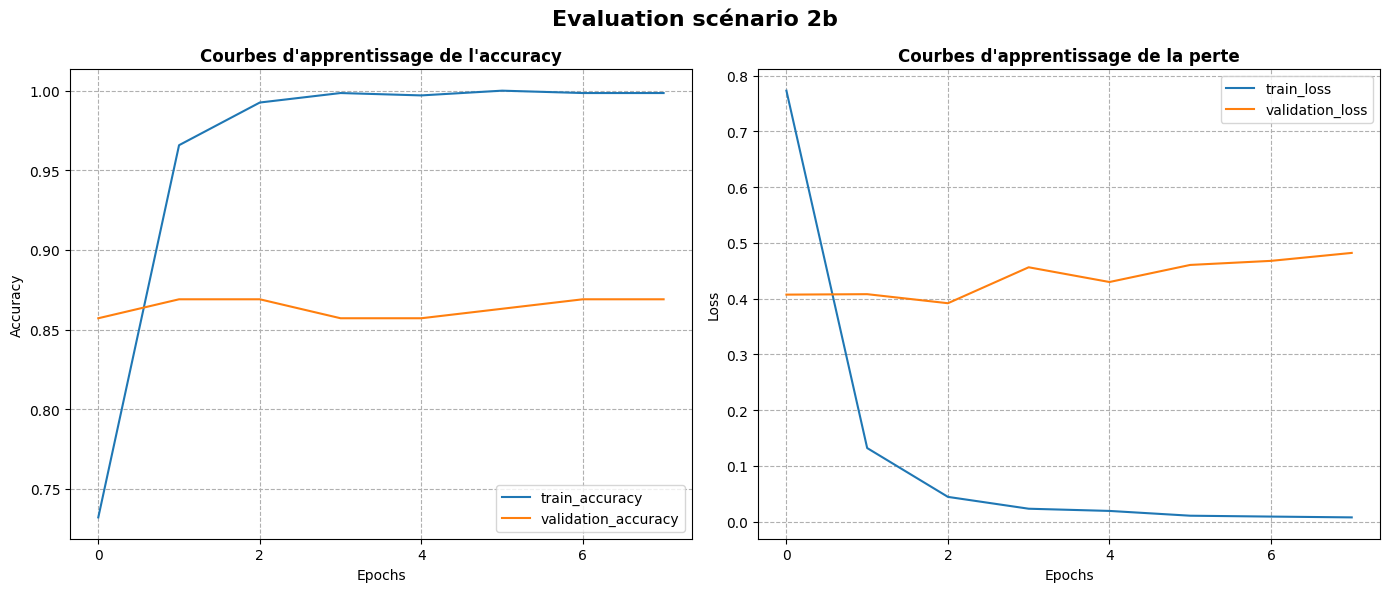

In [22]:
# Récupère le nombre d'EPOCHS utilisés
n_epochs = len(history.history['loss'])

# Affiche les courbes d'apprentissage
plot_learning_curves(history, scenario)

Le modèle a overfit assez rapidement sur les données du jeu d'entraînement et on note aucune amélioration sur la perte de la validation.<br>

In [23]:
# Définit le nom du modèle à charger
model_name = scenario+'_best_model.weights.h5'

# Charger les poids du modèle sauvegardés
model.load_weights(model_name)

# Évaluer le modèle avec les poids chargés
score = model.evaluate(test_generator)
print(f"Test loss: {score[0]}")
print(f"Test accuracy: {score[1]}")

# Ajoute les résultats à la liste de scores
scores.append((scenario, score[1], score[0]))

7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 852ms/step - accuracy: 0.7393 - loss: 0.8080
Test loss: 0.6521669626235962
Test accuracy: 0.7904762029647827


7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step 


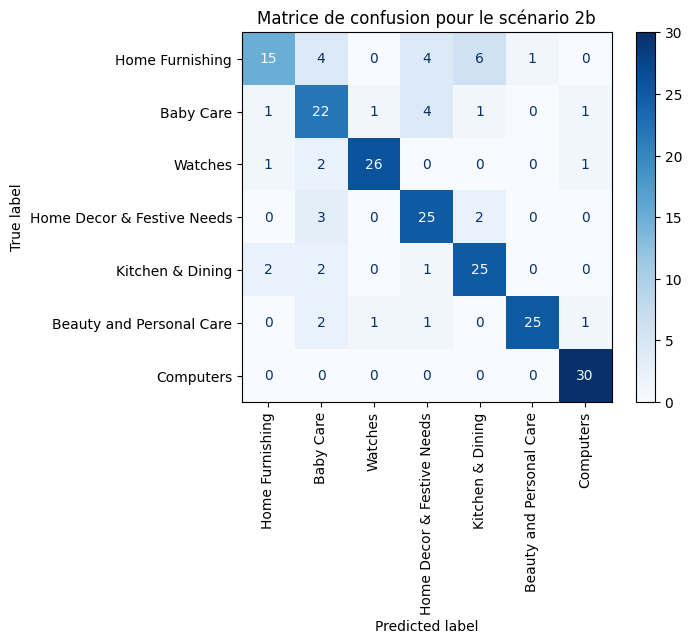

In [24]:
# Récupère les probabilités prédites par le modèle pour chaque classe
y_preds = model.predict(test_generator)

# Calcule la matrice de confusion
cm = confusion_matrix(test_generator.classes, y_preds.argmax(axis=1))

# Crée l'objet de display de la matrice de confusion
cm_display = ConfusionMatrixDisplay(cm, display_labels=labels)

# Affiche la matrice de confusion
cm_display.plot(cmap='Blues', xticks_rotation='vertical')
plt.title(f"Matrice de confusion pour le scénario {scenario}")
plt.show()


On identifique toujours les mêmes problèmes de classification sur les classes `Home Furnishing` et `baby care`.<br>

### **SCENARIO 2c - Transfer Learning avec entraînement de l'output custom G_AVG_POOL + 2X DENSE FC**

Cette fois-ci, on va ajouter une couche Dense supplémentaire pour voir si cela améliore les performances du modèle spécifiquement à nos données.<br>
Cela devrait plus de flexibilité au modèle pour améliorer la classification.<br>

In [25]:
# SCENARIO 2c : On utilise les poids pré-entraînés sur ImageNet ET avec une sortie sans régularisation avec deux dense hidden layer.
scenario = "2c"
data_augmentation_params = None
LEARNING_RATE = 1e-3
N_EPOCHS = 20

# Enregistre les paramètres du modèle
model_params[scenario] = {
    'include_top': False,
    'weights': 'imagenet',
    'input_shape': (224, 224, 3)
}

# Charge le modèle EfficientNetB0
model = EfficientNetB0(**model_params[scenario])

# Gèle toutes les couches du modèle
model.trainable = False

# Affiche les couches du modèle d'entrée et de sortie
print("Input: ", model.input)
print("Output: ", model.output)

# Ajoute les dernières couches denses du modèle
x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
predictions = tf.keras.layers.Dense(n_classes, activation='softmax', name='predictions')(x)

# Crée un modèle à partir des inputs et des outputs
model = Model(inputs=model.input, outputs=predictions)

# Entraine le modèle et affiche les résultats
history = compile_and_fit(model, N_EPOCHS, LEARNING_RATE, scenario=scenario)

Input:  <KerasTensor shape=(None, 224, 224, 3), dtype=float32, sparse=None, name=keras_tensor_963>
Output:  <KerasTensor shape=(None, 7, 7, 1280), dtype=float32, sparse=False, name=keras_tensor_1200>
Found 672 validated image filenames belonging to 7 classes.
Found 168 validated image filenames belonging to 7 classes.
Epoch 1/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 962ms/step - accuracy: 0.5930 - loss: 1.1836

c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



Epoch 1: val_loss improved from inf to 0.54343, saving model to 2c_best_model.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.5991 - loss: 1.1684 - val_accuracy: 0.8571 - val_loss: 0.5434
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 920ms/step - accuracy: 0.9563 - loss: 0.1724
Epoch 2: val_loss improved from 0.54343 to 0.49240, saving model to 2c_best_model.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.9562 - loss: 0.1722 - val_accuracy: 0.8810 - val_loss: 0.4924
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 877ms/step - accuracy: 0.9748 - loss: 0.0691
Epoch 3: val_loss did not improve from 0.49240
21/21 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.9749 - loss: 0.0689 - val_accuracy: 0.8571 - val_loss: 0.5262
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 824ms/step - accuracy: 0.9987 - loss: 0.0149
Epoch 4: val_loss did not improve from 0.49240
21/21 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.9986 - loss: 0.0150 - val_accuracy: 0.8631 - val_loss: 0.5454
Epoch

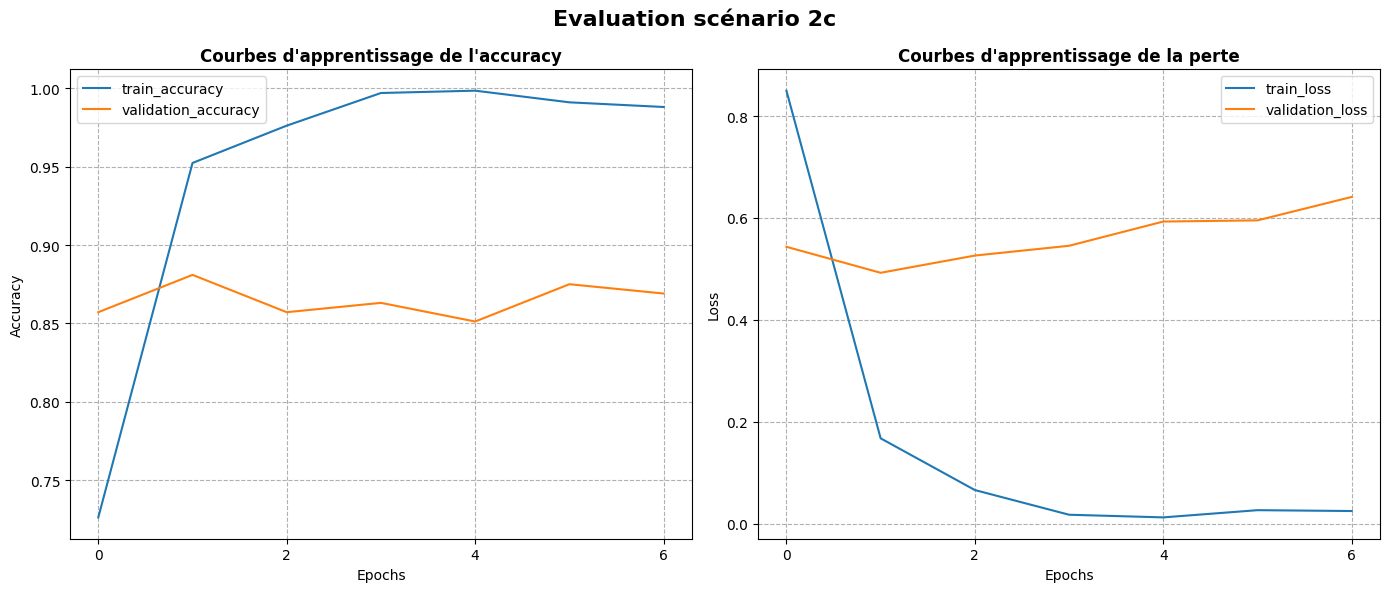

In [26]:
# Récupère le nombre d'EPOCHS utilisés
n_epochs = len(history.history['loss'])

# Affiche les courbes d'apprentissage
plot_learning_curves(history, scenario)

In [27]:
# Définit le nom du modèle à charger
model_name = scenario+'_best_model.weights.h5'

# Charger les poids du modèle sauvegardés
model.load_weights(model_name)

# Évaluer le modèle avec les poids chargés
score = model.evaluate(test_generator)
print(f"Test loss: {score[0]}")
print(f"Test accuracy: {score[1]}")

# Ajoute les résultats à la liste de scores
scores.append((scenario, score[1], score[0]))

7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 848ms/step - accuracy: 0.7469 - loss: 0.8818
Test loss: 0.7093163132667542
Test accuracy: 0.8047618865966797


7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step 


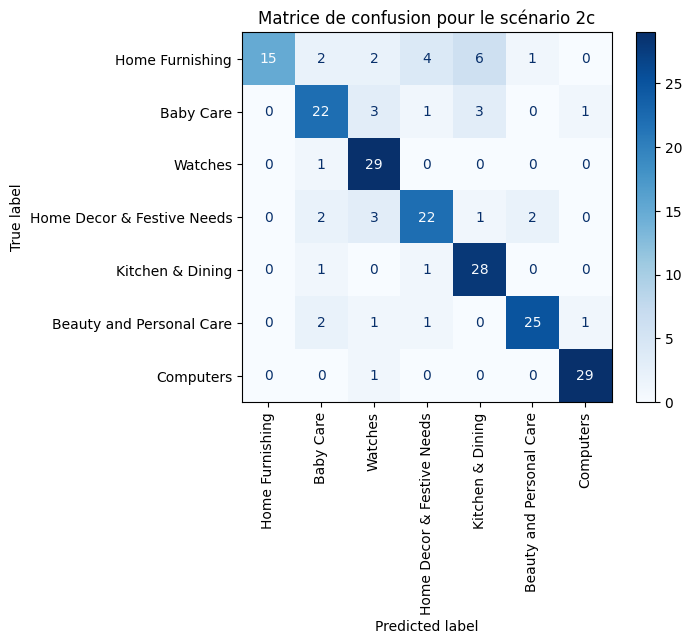

In [28]:
# Récupère les probabilités prédites par le modèle pour chaque classe
y_preds = model.predict(test_generator)

# Calcule la matrice de confusion
cm = confusion_matrix(test_generator.classes, y_preds.argmax(axis=1))

# Crée l'objet de display de la matrice de confusion
cm_display = ConfusionMatrixDisplay(cm, display_labels=labels)

# Affiche la matrice de confusion
cm_display.plot(cmap='Blues', xticks_rotation='vertical')
plt.title(f"Matrice de confusion pour le scénario {scenario}")
plt.show()


Le modèle a réussi à être plus efficace sur les classes qu'il arrivait bien à prédire au détriment toujours des classes qui peuvent se confondre.<br>

### **SCENARIO 3a - Entraîner le modèle 2b avec 4 couches suppl dégelées**

Pour ce scénario, on va dégeler les 4 dernières couches du modèle pour voir si cela améliore les performances du modèle et encore l'aider à s'adapter à nos données.<br>

In [29]:
# SCENARIO 3 : Même modèle que le SCENARIO 2 mais on dégèle les dernières couches du modèle
scenario = '3a'
unfreezed_layers = -6
LEARNING_RATE = 1e-4
N_EPOCHS = 20
data_augmentation_params = None

# Enregistre les paramètres du modèle
model_params[scenario] = {
    'include_top': False,
    'weights': 'imagenet',
    'input_shape': (224, 224, 3)
}

# Charge le modèle EfficientNetB0
model = EfficientNetB0(**model_params[scenario])

# unfreeze layers
for layer in model.layers[unfreezed_layers:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

# Affiche les couches du modèle d'entrée et de sortie
print("Input: ", model.input)
print("Output: ", model.output)

# Ajoute les dernières couches denses du modèle
x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
predictions = tf.keras.layers.Dense(n_classes, activation='softmax', name='predictions')(x)

# Crée un modèle à partir des inputs et des outputs
model = Model(inputs=model.input, outputs=predictions)

# Entraine le modèle et affiche les résultats
history = compile_and_fit(model, N_EPOCHS, LEARNING_RATE, scenario=scenario, data_augmentation_params=data_augmentation_params)

Input:  <KerasTensor shape=(None, 224, 224, 3), dtype=float32, sparse=None, name=keras_tensor_1205>
Output:  <KerasTensor shape=(None, 7, 7, 1280), dtype=float32, sparse=False, name=keras_tensor_1442>
Found 672 validated image filenames belonging to 7 classes.
Found 168 validated image filenames belonging to 7 classes.
Epoch 1/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.2873 - loss: 1.8088

c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



Epoch 1: val_loss improved from inf to 1.14288, saving model to 3a_best_model.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 125s 5s/step - accuracy: 0.2941 - loss: 1.8005 - val_accuracy: 0.7321 - val_loss: 1.1429
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8046 - loss: 0.9881
Epoch 2: val_loss improved from 1.14288 to 0.70433, saving model to 3a_best_model.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 95s 4s/step - accuracy: 0.8057 - loss: 0.9835 - val_accuracy: 0.8095 - val_loss: 0.7043
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9078 - loss: 0.5546
Epoch 3: val_loss improved from 0.70433 to 0.52306, saving model to 3a_best_model.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 94s 4s/step - accuracy: 0.9077 - loss: 0.5523 - val_accuracy: 0.8333 - val_loss: 0.5231
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9184 - loss: 0.3426
Epoch 4: val_loss improved from 0.52306 to 0.44762, saving model to 3a_best_model.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 94s 4s/st

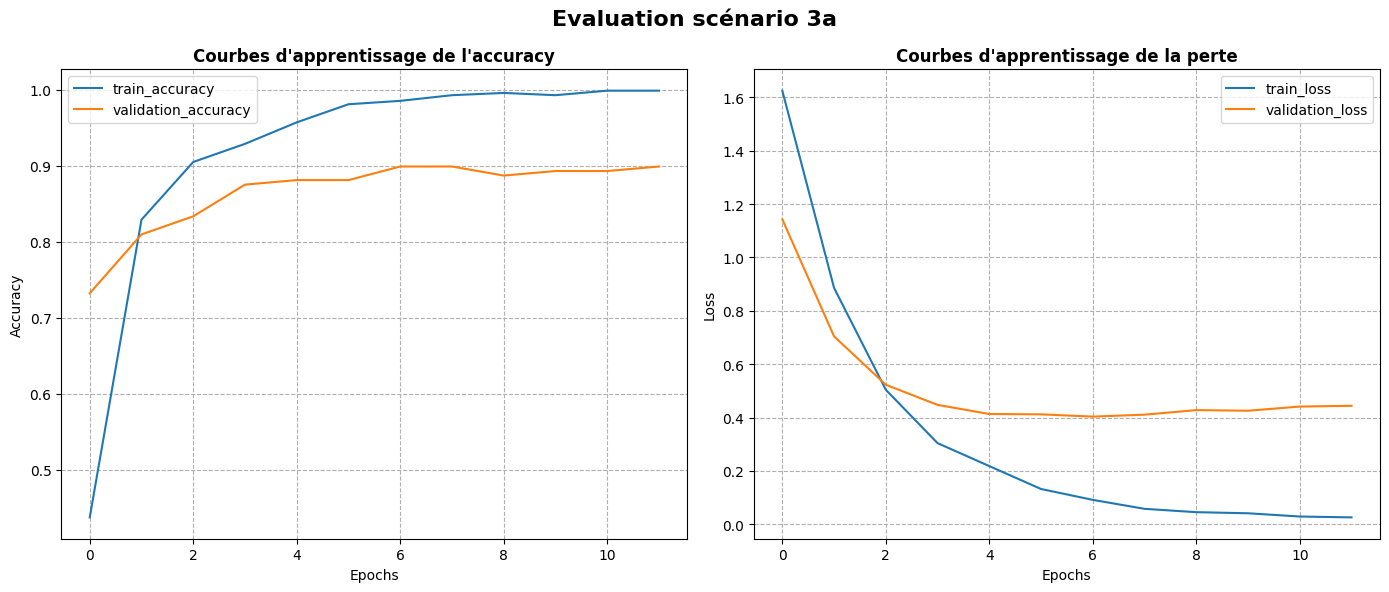

In [30]:
# Récupère le nombre d'EPOCHS utilisés
n_epochs = len(history.history['loss'])

# Affiche les courbes d'apprentissage
plot_learning_curves(history, scenario)

In [31]:
# Définit le nom du modèle à charger
model_name = scenario+'_best_model.weights.h5'

# Charger les poids du modèle sauvegardés
model.load_weights(model_name)

# Évaluer le modèle avec les poids chargés
score = model.evaluate(test_generator)
print(f"Test loss: {score[0]}")
print(f"Test accuracy: {score[1]}")

# Ajoute les résultats à la liste de scores
scores.append((scenario, score[1], score[0]))

7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 792ms/step - accuracy: 0.7650 - loss: 0.7468
Test loss: 0.6440821886062622
Test accuracy: 0.800000011920929


On obtient le meilleur compromis entre les performances sur le jeu de validation et le jeu de test que ce soit au niveau de la perte et de l'accuracy.<br>
Toutefois, l'amélioration reste faible et il semble difficile d'obtenir significativement mieux avec aussi peu de données.<br>

7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step  


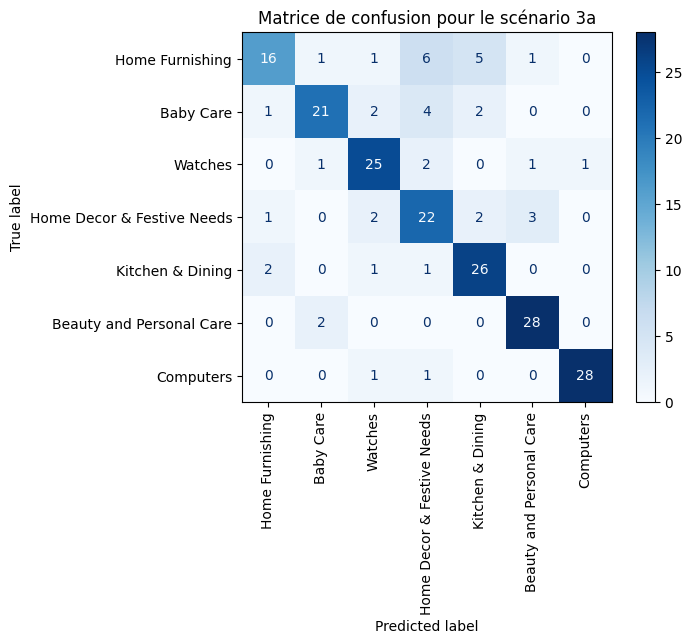

In [32]:
# Récupère les probabilités prédites par le modèle pour chaque classe
y_preds = model.predict(test_generator)

# Calcule la matrice de confusion
cm = confusion_matrix(test_generator.classes, y_preds.argmax(axis=1))

# Crée l'objet de display de la matrice de confusion
cm_display = ConfusionMatrixDisplay(cm, display_labels=labels)

# Affiche la matrice de confusion
cm_display.plot(cmap='Blues', xticks_rotation='vertical')
plt.title(f"Matrice de confusion pour le scénario {scenario}")
plt.show()


Mêmes remarques de précemment sur les classes mal prédites.<br>

### **SCENARIO 4a - Entraîner le modèle 3a AVEC Data augmentation**

On ajoute par rapport au dernier scénario de la data augmentation sur nos images pour induire du bruit et permettre au modèle de mieux généraliser.<br>

In [33]:
# SCÉNARIO 4 : On utilise le même modèle que le SCENARIO 3 mais on rajoute de la data augmentation
scenario = '4a'
N_EPOCHS = 25
LEARNING_RATE = 1e-4
data_augmentation_params = {
    'width_shift_range': 0.2,
    'height_shift_range': 0.2,
    'zoom_range': 0.2,
    'horizontal_flip': True,
    'vertical_flip': True
}

# Enregistre les paramètres du modèle
model_params[scenario] = {
    'include_top': False,
    'weights': 'imagenet',
    'input_shape': (224, 224, 3)
}

# Charge le modèle EfficientNetB0
model = EfficientNetB0(**model_params[scenario])

# Affiche les couches du modèle d'entrée et de sortie
print("Input: ", model.input)
print("Output: ", model.output)

# Ajoute les dernières couches denses du modèle
x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
predictions = tf.keras.layers.Dense(n_classes, activation='softmax', name='predictions')(x)

# Crée un modèle à partir des inputs et des outputs
model = Model(inputs=model.input, outputs=predictions)

# Entraine le modèle et affiche les résultats
history = compile_and_fit(model, N_EPOCHS, LEARNING_RATE, scenario=scenario, data_augmentation_params=data_augmentation_params)

Input:  <KerasTensor shape=(None, 224, 224, 3), dtype=float32, sparse=None, name=keras_tensor_1446>
Output:  <KerasTensor shape=(None, 7, 7, 1280), dtype=float32, sparse=False, name=keras_tensor_1683>
Found 672 validated image filenames belonging to 7 classes.
Found 168 validated image filenames belonging to 7 classes.
Epoch 1/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.2878 - loss: 1.8504

c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



Epoch 1: val_loss improved from inf to 1.32906, saving model to 4a_best_model.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 121s 4s/step - accuracy: 0.2932 - loss: 1.8430 - val_accuracy: 0.6012 - val_loss: 1.3291
Epoch 2/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7765 - loss: 1.1232
Epoch 2: val_loss improved from 1.32906 to 0.87246, saving model to 4a_best_model.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 92s 4s/step - accuracy: 0.7755 - loss: 1.1194 - val_accuracy: 0.7619 - val_loss: 0.8725
Epoch 3/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8146 - loss: 0.7380
Epoch 3: val_loss improved from 0.87246 to 0.63287, saving model to 4a_best_model.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 92s 4s/step - accuracy: 0.8150 - loss: 0.7362 - val_accuracy: 0.7976 - val_loss: 0.6329
Epoch 4/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8523 - loss: 0.5136
Epoch 4: val_loss improved from 0.63287 to 0.62484, saving model to 4a_best_model.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 93s 4s/st

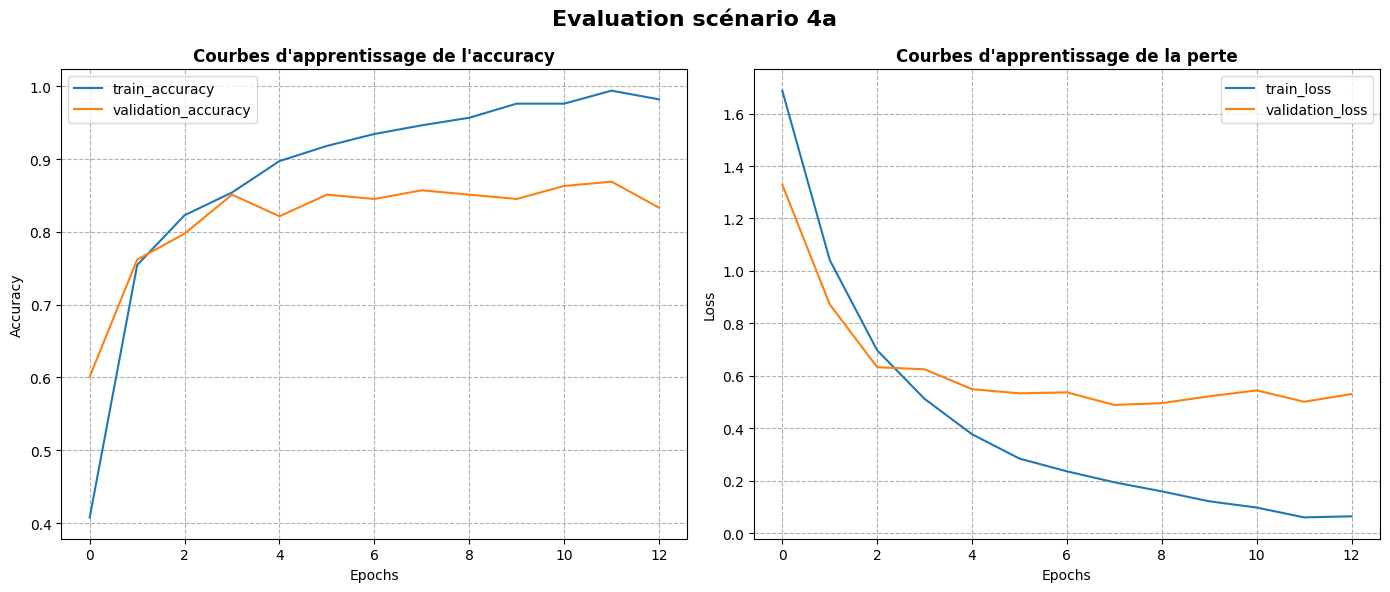

In [34]:
# Récupère le nombre d'EPOCHS utilisés
n_epochs = len(history.history['loss'])

# Affiche les courbes d'apprentissage
plot_learning_curves(history, scenario)

Avec la data augmentation, les courbes d'apprentissage divergent assez rapidement et le modèle a du mal à généraliser les données.<br>
Il semble que les images telles que présentés par les vendeurs ne sont pas très variées et la data augmentation n'a pas aidé le modèle à mieux généraliser.<br>

In [35]:
# Définit le nom du modèle à charger
model_name = scenario+'_best_model.weights.h5'

# Charger les poids du modèle sauvegardés
model.load_weights(model_name)

# Évaluer le modèle avec les poids chargés
score = model.evaluate(test_generator)
print(f"Test loss: {score[0]}")
print(f"Test accuracy: {score[1]}")

# Ajoute les résultats à la liste de scores
scores.append((scenario, score[1], score[0]))

7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 750ms/step - accuracy: 0.7651 - loss: 0.7100
Test loss: 0.6355261206626892
Test accuracy: 0.7904762029647827


7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 979ms/step


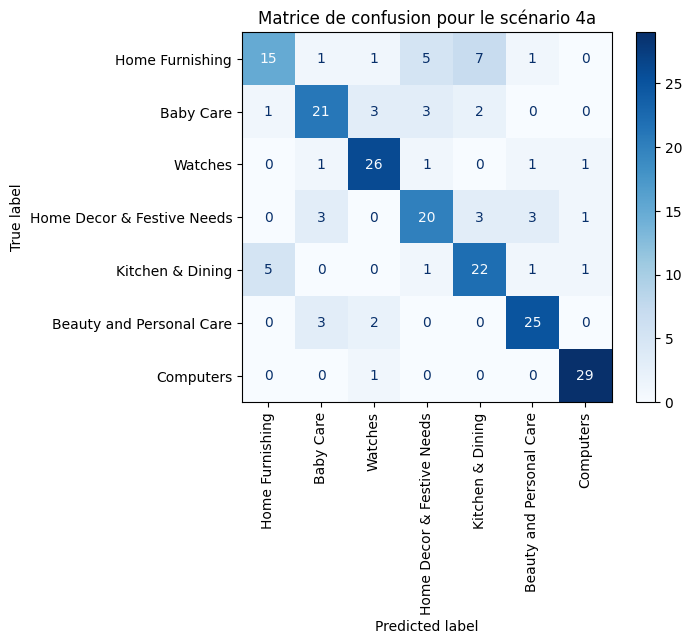

In [36]:
# Récupère les probabilités prédites par le modèle pour chaque classe
y_preds = model.predict(test_generator)

# Calcule la matrice de confusion
cm = confusion_matrix(test_generator.classes, y_preds.argmax(axis=1))

# Crée l'objet de display de la matrice de confusion
cm_display = ConfusionMatrixDisplay(cm, display_labels=labels)

# Affiche la matrice de confusion
cm_display.plot(cmap='Blues', xticks_rotation='vertical')
plt.title(f"Matrice de confusion pour le scénario {scenario}")
plt.show()


Le scénario avec la data augmentation a été testé mais n'a pas donné de meilleurs résultats que le scénario 3a.<br>
Comparons les résultats finaux.


# **Comparaison des performances des différents scénarios**

In [37]:
scores_df = pd.DataFrame(scores, columns=['Scenario', 'Accuracy', 'Loss'])
print(scores_df)

  Scenario  Accuracy      Loss
0        1  0.142857  1.956160
1       2a  0.785714  0.662220
2       2b  0.790476  0.652167
3       2c  0.804762  0.709316
4       3a  0.800000  0.644082
5       4a  0.790476  0.635526


On écarte le modèle from scratch qui n'a pas donné de bons résultats.<br>

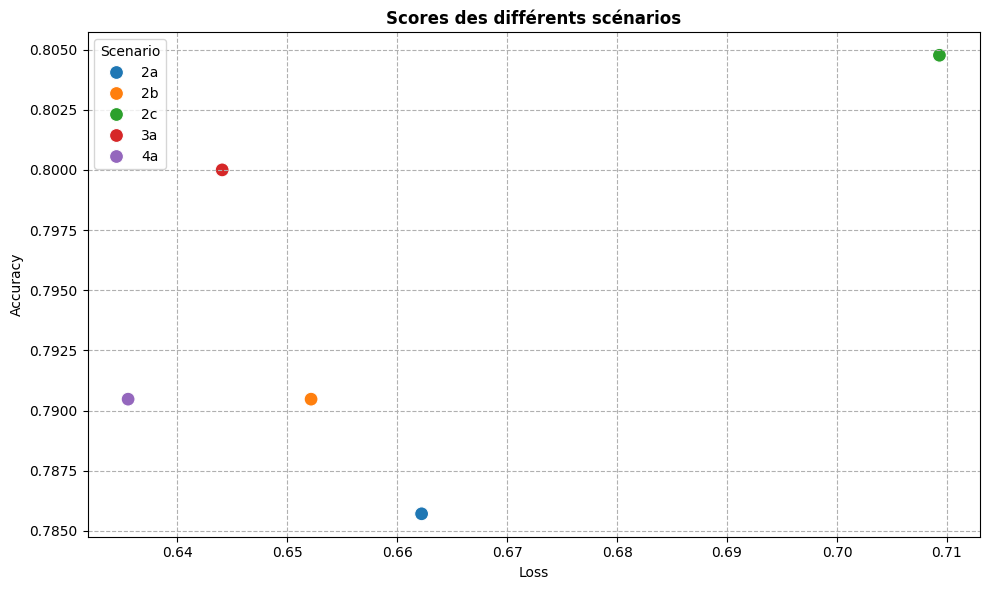

In [38]:
# crée un scatterplot pour afficher les scores
fig, ax = plt.subplots(figsize=(10, 6), tight_layout=True)
scores_df[scores_df['Accuracy']>0.5].pipe(sns.scatterplot, x='Loss', y='Accuracy', hue='Scenario', s=100, ax=ax)
ax.set_title("Scores des différents scénarios", fontweight='bold')
ax.grid(axis='both', linestyle='--')
plt.show()

On retrouve le scénario 3a qui a donné le meilleur compromis sur la perte et l'accuracy sur le jeu de test.<br>
Le scénario 4a avec la data augmentation est celui qui minimise davantage la perte.<br>
Ce modèle sera assez performant mais devrait être limité par ces catégories qui se confondent.<br>
L'utilisation du texte pourrait peut être aider à mieux distinguer ces catégories.<br>